# Calibrating Classifiers

## Business Motivation

Sometimes we care more about the predicted probabilities from a classifier than the predicted label. Small discrepencies between predicted and true probabilities can matter a lot in certain contexts. 

For example, if we want to know a customers expected revenue, we could multiply the probability that they buy an item times the cost of the item. Say there is a 1% chance a user buys item X which costs \$60 value, making their expected revenue \$0.06. If we trained a model to predict this probability on past data we would want to upsample the cases where customers bought item X to balance the data. This will likely lead to overestimated predicted probabilities. If the model predicts even a slightly inflated probability of purchase, say 3%, the expected revenue jumps to \$0.18. Thinking that an item is 3x more valuable to the business than it actually is could lead to very poor business decisions.

## Calibration Plots and Brier Score

We can visualize this problem with Calibration Plots. On the X-axis is the predicted probability and on the y-axis is the actual proportion of the positive class for those predicted probabilities. A straight line along (0, 0) to (1, 1) yields "perfect calibration", e.g. a predicted probability of 0.3 should have a positive label 30% of the time. 

Typically these plots are built with bucketing, so all observations in a given bucket on the x-axis are used to calculate the proportion of the positive class to be plotted on the y-axis, e.g. all observations in a bucket centered around 0.3, should have 30% positive labels.

You can see below how uncalibrated classifiers might fall above and below this perfect calibration line, meaning their predicted probabilities are wrong.

<img src="calibration_plots.png" height="700" />

We can also get a numerical measure of calibration with the Brier Score:

$$\text{Brier Score} = \frac{1}{N} \sum_{i=1}^N (p_i - y_i)^2$$

Where

* $N$: The total number of predictions.
* $p_i$: The predicted probability for the positive class for instance i.
* $y_i$: The actual outcome for instance $i$, which is 1 for the positive class and 0 for the negative class.

The Brier Score is between 0 and 1 with a lower value indicating better calibration.

## Calibrating a Classifier with Plat Scaling

Plat scaling applies logistic regression to the predicited probabilities of a classifier to "scale" them to the true probabilities. At a high level this is how it works:

1. Train a classifier model on dataset A with features $X_{A}$ and outcome $Y_{A\_labels}$
2. Predict probabilities of dataset B with features $X_{B}$ to get $Y_{B\_probs}$

Assume we have chosen a logistic regression classifier:

$$ Y_{B\_probs} = \frac{1}{1 + e^{-(\beta_0 + \beta^\top \mathbf{X_B})}} $$

Where $\beta$ and $\beta_0$ are the coefficients and intercept found from Step 1.

3. Train a logistic regression model with input $Y_{B\_probs}$ and output $Y_{B\_labels}$

$$ P(Y = 1 | Y_{B\_probs}) = \frac{1}{1 + e^{-(\alpha_0 + \alpha_1 \mathbf{Y_{B\_probs}})}} $$

## An Example with scikit-learn


In [69]:
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score, brier_score_loss

X, y = make_classification(
    n_samples=1000,          
    n_features=20,          
    n_informative=2,         
    n_redundant=10,          
    n_clusters_per_class=1,  
    weights=[0.9, 0.1],      # Proportion of the classes (90% to 10%)
    flip_y=0,                
    random_state=42            
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        
    stratify=y,           # Ensures the class distribution is preserved
    random_state=42       
)

### Fit with No Calibration and No Resampling

Average Precision: 0.9050 
Brier Score:0.0180


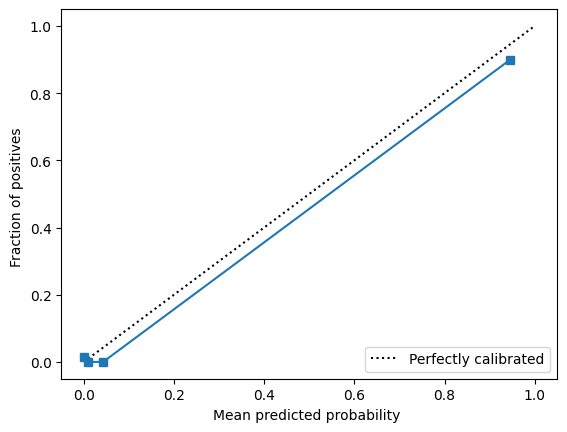

In [72]:
pipeline = Pipeline([('model', RandomForestClassifier(random_state=42))])
pipeline.fit(X_train, y_train)

y_probs = pipeline.predict_proba(X_test)[:, 1]

ap = average_precision_score(y_test, y_probs)
brier_score = brier_score_loss(y_test, y_probs)
print(f"Average Precision: {ap:.4f} \nBrier Score:{brier_score:.4f}")

prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins = 10, strategy  = 'quantile')
CalibrationDisplay(prob_true, prob_pred, y_probs).plot()

### Fit with SMOTE Resampling and No Calibration

Average Precision: 0.9412 
Brier Score:0.0231


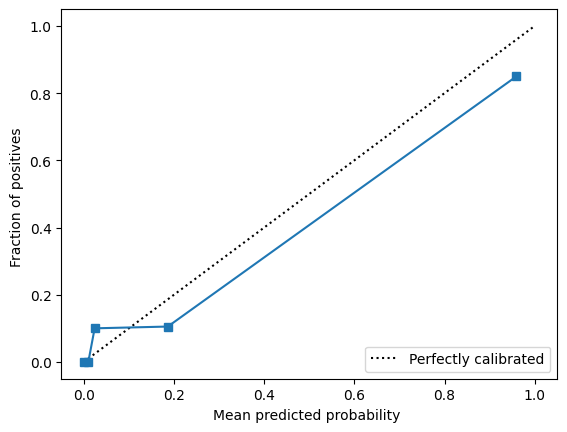

In [73]:
pipeline = Pipeline([('resampler', SMOTE(random_state = 42)), ('model', RandomForestClassifier(random_state=42))])
pipeline.fit(X_train, y_train)

y_probs = pipeline.predict_proba(X_test)[:, 1]

ap = average_precision_score(y_test, y_probs)
brier_score = brier_score_loss(y_test, y_probs)
print(f"Average Precision: {ap:.4f} \nBrier Score:{brier_score:.4f}")

prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins = 10, strategy  = 'quantile')
CalibrationDisplay(prob_true, prob_pred, y_probs).plot()

### Fit with Calibration

Average Precision: 0.9472 
Brier Score:0.0203


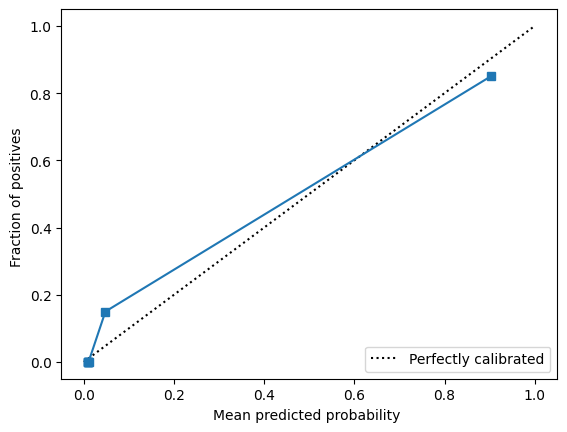

In [74]:
pipeline = Pipeline([('resampler', SMOTE(random_state = 42)), ('model', RandomForestClassifier(random_state=42))])
calibrated_cv = CalibratedClassifierCV(estimator = pipeline)
calibrated_cv.fit(X_train, y_train)

y_probs = calibrated_cv.predict_proba(X_test)[:, 1]

ap = average_precision_score(y_test, y_probs)
brier_score = brier_score_loss(y_test, y_probs)
print(f"Average Precision: {ap:.4f} \nBrier Score:{brier_score:.4f}")

prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins = 10, strategy  = 'quantile')
CalibrationDisplay(prob_true, prob_pred, y_probs).plot()